
# Portfolio Optimization and Backtesting Notebook

After obtaining and cleaning the necessary data in the previous notebook, this notebook focuses on the core tasks of portfolio optimization and backtesting. Key objectives of this notebook are:
- Performing portfolio optimization to find the optimal weights for assets.
- Backtesting the optimized portfolio against historical data to evaluate its performance.
- Comparing the portfolio's performance with market benchmarks.

Let's begin by setting up the environment and importing the cleaned data.

### Library Imports and Initial Setup

Import all necessary libraries and set up initial dataframe for data analysis and visualization.

In [1]:
import numpy as np
import numpy.random as npr
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import scipy.optimize as sco

In [2]:
from project_functions import get_beta

In [3]:
# Getting data still from runing the data clceaning jupyter file:
%run data_cleaning_formatting.ipynb

Enter 'short' or 'long' for the time interval you want to analyse data for(or press Enter to use the default): 
You have selected: short
Enter the stock ticker for stock (or press Enter to use the default) 1: 
you have choosed the default stock list
You have choosed the following stock tickers: AAPL, ORCL, NVDA


In [4]:
# Again, here we are making sure that we are not including the market index into our latter calculation 
list_copy = list_copy[0:3]

### Preparing market returns data:
As we would want to compare our final result against the market, we would first want to make to we have our hand on some market data

In [5]:
# Preparing market performance data for later use in the comparision stage:
market = market_return[(market_return['date'].dt.year == 2023) & ((market_return['date'].dt.month == 8) | (market_return['date'].dt.month == 9))]
market = market.iloc[::-1].reset_index(drop=True)


market['ret'] = market.groupby("ticker")['close'].apply(lambda x: x.pct_change(1))
market = market.pivot(columns='ticker', values='ret', index='date')

market = market = 1 + market # to obtain gross returns

# Putting the weight on the first row, as the initial investment
market.iloc[0, :] = 1

# Start rollover the investment, without considering rebalancing:
market = market.cumprod()
market['market_return'] = market['SPY'].pct_change()  

# Zero Beta Portfolio:
- The Zero Beta Portfolio is a theoretical portfolio that has zero correlation with the market. It's a valuable concept in portfolio theory, as it allows us to understand the risk-return profile of a portfolio that is completely insulated from market movements. In this section, we aim to build a Zero Beta Portfolio.

In [6]:
# This funciton will be the objective function to optimized for finding a zero beta portfolio:
def obj(weight, group, model_name, data):

    # Dictionary to define how many betas each model uses
    beta_counts = {'capm': 1, 'fama': 3, 'momentum': 4}

    # Ensure the model name is valid
    if model_name not in beta_counts:
        raise ValueError("Invalid model name")

    # Compute the sum for each beta * weight based on the model
    port_beta = sum([np.sum(data[f"beta{i}"] * weight) for i in range(1, beta_counts[model_name] + 1)])
    return port_beta

# The function for optimization process:
def opt_port(stocks, data, model_name):
    initial_input = [1/len(stocks)] * len(stocks)
    
    arguments = (stocks, model_name, data)

    # We set the constraint that weight will sum up to 1:
    cons=({'type':'eq', 'fun':lambda w: np.sum(w) - 1},
      {'type':'eq', 'fun': lambda x: obj(x, *arguments)})

    opt_S = sco.minimize(obj, initial_input, args=arguments, method='SLSQP', constraints=cons)
    
    return opt_S

## Under CAPM:

In [7]:
# Getting beta first using the get_beta function we defined and saved in the my_functions file:
beta_dict = get_beta('capm', final_data, list_copy)
df = pd.DataFrame(beta_dict).T
df.columns = ['beta1']
print(df)

         beta1
AAPL  0.949216
ORCL  1.479559
NVDA  2.705572


In [8]:
# Run the optimization:
opt_S = opt_port(list_copy, df, 'capm')

In [9]:
# Here, we extract the result for portfolio weight, and rounded to 5 decimal places
weight_high = opt_S['x'].round(5)

weight_high

array([ 1.13708,  0.57785, -0.71493])

## Fama-French Three-Factor Model

In [10]:
beta_dict = get_beta('fama', final_data, list_copy)
df2 = pd.DataFrame(beta_dict).T
df2.columns = ['beta1', 'beta2', 'beta3']
print(df2)

         beta1     beta2     beta3
AAPL  0.912998 -0.000513 -0.003701
ORCL  1.526298 -0.005870 -0.006477
NVDA  2.801011 -0.009206 -0.008437


In [11]:
opt_S = opt_port(list_copy, df2, 'fama')

# Here, we extract the result for portfolio weight, and rounded to 5 decimal places
weight_high = opt_S['x'].round(5)

weight_high

array([ 1.11693,  0.54323, -0.66016])

## Momentum Model

In [12]:
beta_dict = get_beta('momentum', final_data, list_copy)
df3 = pd.DataFrame(beta_dict).T
df3.columns = ['beta1', 'beta2', 'beta3', 'beta4']
print(df3)

         beta1     beta2     beta3     beta4
AAPL  0.927958 -0.000298 -0.003210  0.000863
ORCL  1.601146 -0.004790 -0.004024  0.004319
NVDA  3.116377 -0.004654  0.001902  0.018196


In [13]:
opt_S = opt_port(list_copy, df3, 'momentum')

weight_high = opt_S['x'].round(5)

weight_high

array([ 1.03989,  0.54542, -0.5853 ])

Note: we can see that the  sweight give from the 3 models seems to be very close together, so in latter comparision stage, we will only use the weight calculated by the momentum model for better clarity of plot.

In [14]:
# Making sure the weight are align to the stocks orders:
weight_high[-2:], weight_high[-1] = weight_high[-1], weight_high[-2]

# Max Sharp Ratio Portfolio:
- he Max Sharpe Ratio Portfolio is the portfolio on the efficient frontier that provides the highest excess return per unit of risk. The Sharpe ratio measures this risk-adjusted performance by taking the portfolio's excess return (the return above the risk-free rate) and dividing it by its standard deviation. 
- In simple word, this is a selection of investments that aims to give you the highest return for the amount of risk you're taking. 

In [15]:
def port_sharp(x):
    weight_list = np.array(x)
    # Compute portfolio expected return
    portfolio_return = np.sum(final_data.groupby('ticker')['ex_return'].mean() * weight_list)

    # Compute portfolio variance
    cov_matrix = final_data.pivot_table(values='ex_return', columns='ticker', index='date').cov()
    portfolio_variance = np.dot(weight_list.T, np.dot(cov_matrix,  weight_list))

    # Compute portfolio Sharpe Ratio
    rf_rate = final_data['rf'].mean() 
    portfolio_sharpe = (portfolio_return - rf_rate) / np.sqrt(portfolio_variance)

    return [portfolio_sharpe, portfolio_variance]


def Sharpe(weights): 
    return -port_sharp(weights)[0]


In [16]:
# With max sharp ratio and min variance portfolio optimization, we added a part where we would try out different starting weight
# for the optimization, to try to avoid stopping at a local minimal.

def random_initial_weights(n_assets):
    # Generate random initial weights that sum up to 1.
    weights = np.random.rand(n_assets)
    return weights / np.sum(weights)

In [17]:
# Number of random initializations
n_attempts = 500
best_sharp = -100
best_weight_sharp = None

cons={'type':'eq', 'fun':lambda w: np.sum(w)-1}
bnds=tuple((0,1) for x in range(len(list_copy)))

for _ in range(n_attempts):
    init_weights = random_initial_weights(len(list_copy))
    opt_results = sco.minimize(Sharpe, init_weights, method='SLSQP', bounds=bnds, constraints=cons)
    
    # Check if this is the best solution so far
    if opt_results['fun'] > best_sharp:
        best_sharp = opt_results['fun']
        best_weights_sharp = opt_results['x']

best_weights_sharp, best_sharp

(array([0.0000000e+00, 1.0000000e+00, 7.7393647e-13]), 1.5983838071586358)

In [18]:
print (best_weights_sharp.round(3)) # weights

[0. 1. 0.]


# Min Variance Portfolio:
- The Min Variance Portfolio is the portfolio on the efficient frontier with the lowest possible risk, as measured by the standard deviation of its returns. This portfolio is constructed by optimizing asset weights to minimize the portfolio's overall variance, without considering the expected returns of the individual assets.
- This is a mix of investments chosen to have the smallest ups and downs over time.

In [19]:
def Variance(initial_weight):
    return port_sharp(initial_weight)[1]


In [20]:
# Number of random initializations

n_attempts = 1000
best_variance = float('inf')
best_weights = None

for _ in range(n_attempts):
    init_weights = random_initial_weights(len(list_copy))
    opt_results = sco.minimize(lambda z: Variance(z), init_weights, method='SLSQP', bounds=bnds, constraints=cons)
    
    # Check if this is the best solution so far
    if opt_results['fun'] < best_variance:
        best_variance = opt_results['fun']
        best_weights = opt_results['x']

best_weights, best_variance

(array([0.93176322, 0.01457757, 0.05365921]), 8.464855235873719e-05)

In [21]:
print (best_weights.round(3) * 100) # weights

[93.2  1.5  5.4]


# Backtesting Optimized Portfolios 
In this section, we will be evaluating the performance of our optimized portfolio. We'll compare our portfolio's hypothetical performance against historical data to gauge its effectiveness. This will provide insights into how our portfolio might perform under similar market conditions in the future.

In [22]:
# Setting up the historiical return data needed for backtesting:
backtesting_data['ret'] = backtesting_data.groupby('ticker')['close'].apply(lambda x: x.pct_change(1))
test_data = backtesting_data.pivot(columns='ticker', values='ret', index='date')

###  Portfolio # 1 (zero beta)

In [23]:
test_data_1 = 1 + test_data # to obtain gross returns

# Putting the weight on the first row, as the initial investment
test_data_1.iloc[0, :] = weight_high

# Start rollover the investment, without considering rebalancing:
test_data_1 = test_data_1.cumprod()

test_data_1['portfolio_value'] = test_data_1.sum(axis=1)  


test_data_1['portfolio_return'] = test_data_1['portfolio_value'].pct_change()  

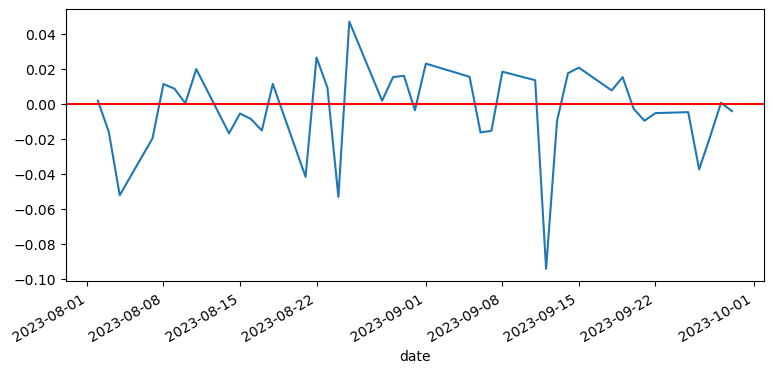

In [24]:
# a small plot showing how the returns fluctuated:
test_data_1['portfolio_return'].plot(figsize=(9,4))
plt.axhline(y=0,c='r')

###  Portfolio # 2 (max sharp)

In [25]:
test_data_2 = 1 + test_data # to obtain gross returns

# Putting the weight on the first row, as the initial investment
test_data_2.iloc[0, :] = best_weights_sharp

# Start rollover the investment, without considering rebalancing:
test_data_2 = test_data_2.cumprod()

test_data_2['portfolio_value'] = test_data_2.sum(axis=1)  


test_data_2['portfolio_return'] = test_data_2['portfolio_value'].pct_change()  

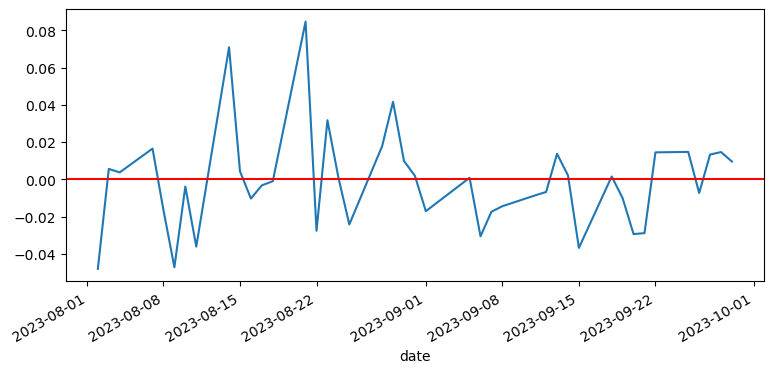

In [26]:
test_data_2['portfolio_return'].plot(figsize=(9,4))
plt.axhline(y=0,c='r')

###  Portfolio # 3 (min variance)

In [27]:
test_data_3 = 1 + test_data # to obtain gross returns

# Putting the weight on the first row, as the initial investment
test_data_3.iloc[0, :] = best_weights

# Start rollover the investment, without considering rebalancing:
test_data_3 = test_data_3.cumprod()

test_data_3['portfolio_value'] = test_data_3.sum(axis=1)  


test_data_3['portfolio_return'] = test_data_3['portfolio_value'].pct_change()  


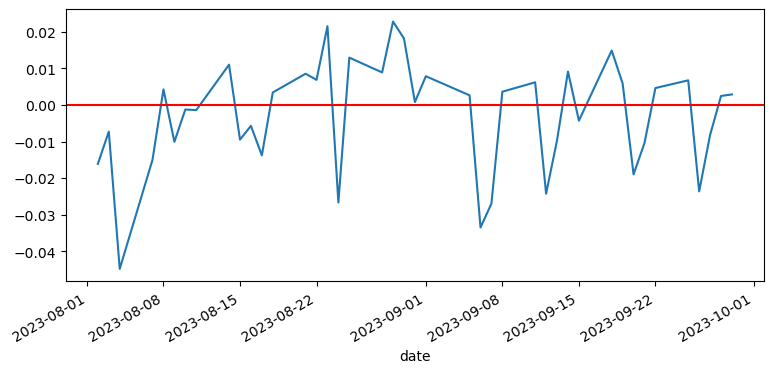

In [28]:
test_data_3['portfolio_return'].plot(figsize=(9,4))
plt.axhline(y=0,c='r')

## Comparision across portfolios:

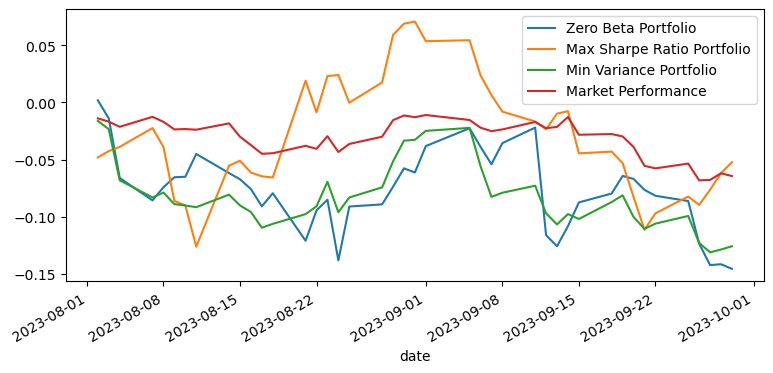

In [29]:
plt.figure(figsize=(9, 4))

test_data_1['portfolio_return'].cumsum().plot(label='Zero Beta Portfolio')
test_data_2['portfolio_return'].cumsum().plot(label='Max Sharpe Ratio Portfolio')
test_data_3['portfolio_return'].cumsum().plot(label='Min Variance Portfolio')
market['market_return'].cumsum().plot(label = 'Market Performance')
plt.legend()
plt.show()

## **Analysis And Conclusion:**

### **Observations:**

#### **1. Zero Beta Portfolio:**
- **Performance**: Exhibited non-steady growth and drop throughout the backtest period. However, its ending value was marginally below that of the market.
  
- **Volatility**: Displayed a rather high volatility compared to other portfolios and the market.
  
- **Analysis**: The zero-beta portfolio's aim is to be uncorrelated with the market, offering consistent returns irrespective of market conditions. This portfolio appears to somewhat achieve this, with its movement relatively differ from the market.

#### **2. Max Sharpe Ratio Portfolio:**
- **Performance**: Achieved the highest ending value among all portfolios, surpassing the market.
  
- **Volatility**: Experienced high fluctuations but effectively captured upward market trends.
  
- **Analysis**: The goal of the max Sharpe ratio portfolio is to provide the best risk-adjusted return. Not only did it outperform the market, but it also exceeded the other portfolios, suggesting a good balance of risk and reward.

#### **3. Min Variance Portfolio (test_data_3):**
- **Performance**: Concluded with an ending value below the max Sharpe ratio portfolio and the market.
  
- **Volatility**: Showed similar volatility to the zero beta portfolio.
  
- **Analysis**: The min variance portfolio, intended to minimize volatility, does seem to fully meet this objective. However, its performance isn't the best amongs all.


### **Discussions:**

#### **Risk and Reward:**
- **Balance**:  The max Sharpe ratio portfolio stood out in balancing risk and reward, achieving high returns while navigating market volatility. On top of that, it's good to note that the zero-beta portfolio, as designed to be uncorrelated with the market, it succesefully displayed a different movement than the market. However, the end result also shows that while it did differentiate from the market, it did not necessarily provide a safer haven.(during the backtest period).
  
- **Trade-offs**: The min variance portfolio, although aiming for minimized risk, seemed to also miss out on potential returns, indicating a trade-off that investors should be aware of.

#### **Performance vs. Market:**
- **Benchmarking**: Only the max sharp portfolio emerged as a strong contender, beating the market benchmark, but this may not be the case again, with different input of stocks, and the choose of index.


### **Conclusion:**

   The backtest results, derived from historical stock data, provide valuable insights into the effectiveness of the portfolio optimization process. While the max sharp portfolio showcased superior return, the zero-beta portfolio catered to those seeking stability. 
   
   As always, it's essential for us to remember that backtesting uses historical data and cannot guarantee future performance.